In [1]:
EPOCH = 'Training Epoch'
CROP_SIZE = 'Crop size'
PROC = 'Procedure'
COCO_AP = 'COCO AP'
COCO_AP_BIN = 'COCO AP (binary clf)'
RECOG_AP = 'mAP'

In [2]:
PROC_1 = "Proc. 1"# (Conventional detector training)"
PROC_2 = "Proc. 2"# (Two-phase training)"
PROC_3 = "Proc. 3"# (Crop batch training)"
PROC_4 = "Proc. 4"# (Task-specific training)"

In [3]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
import wandb


res_path = Path('procedure_results.pkl')
LAZY = True


def get_results():
    api = wandb.Api()

    SWEEPS = {
        "sandbox_experiments/ae74qmol": PROC_1,
        "sandbox_experiments/6wecie9y": PROC_2,
        "experiments/dyuqidka": PROC_3,
        "experiments/yenmkqwi": PROC_3,
    }

    results = []

    for sweep_suffix, proc_name in tqdm(SWEEPS.items()):
        sweep = api.sweep(f"jpdr/{sweep_suffix}")
        runs = sweep.runs

        for run in tqdm(runs, leave=False):
            df_history = run.history(keys=[
                "COCO_recog/AP@[0.50:0.95]",
                "epoch",
            ])
            df_history = pd.concat([
                df_history,
                run.history(keys=[
                    "COCO_detect/AP@[0.50:0.95]",
                    "epoch",
                ])
            ])
            df_history = pd.concat([
                df_history,
                run.history(keys=[
                    "AggPRCurve/mAP",
                    "epoch",
                ])
            ])
            df_history[PROC] = proc_name
            df_history[CROP_SIZE] = run.config['crop_box_size']
            df_history['val_fold'] = run.config['k_fold_val_fold']
            results.append(df_history)

    df = pd.concat(results, ignore_index=True)
    return df


if not res_path.exists() or not LAZY:
    df = get_results()
    df.to_pickle(res_path)
else:
    df = pd.read_pickle(res_path)


df = df.rename(columns={
    'epoch': EPOCH,
    'COCO_recog/AP@[0.50:0.95]': COCO_AP,
    "COCO_detect/AP@[0.50:0.95]": COCO_AP_BIN,
    "AggPRCurve/mAP": RECOG_AP,
})

df.loc[(df[PROC] == PROC_4), CROP_SIZE] = -1

In [4]:
PROCS_3_4 = []

crop_sizes_names = [
    str(s) for s in df[CROP_SIZE].unique()
    if isinstance(s, int)
]
crop_sizes_names = sorted(crop_sizes_names, reverse=True)


for i, size in enumerate(crop_sizes_names):
    size = int(size)
    char = 'ABCDEFG'[i]
    new_proc = f'{PROC_3[:7]}{char}{PROC_3[7:-1]}, {size}px'
    PROCS_3_4.append(new_proc)
    df.loc[(df[PROC] == PROC_3)
        & (df[CROP_SIZE] == size), PROC] = new_proc

PROCS_3_4.append(PROC_4)

In [5]:
fig_path = Path('.')

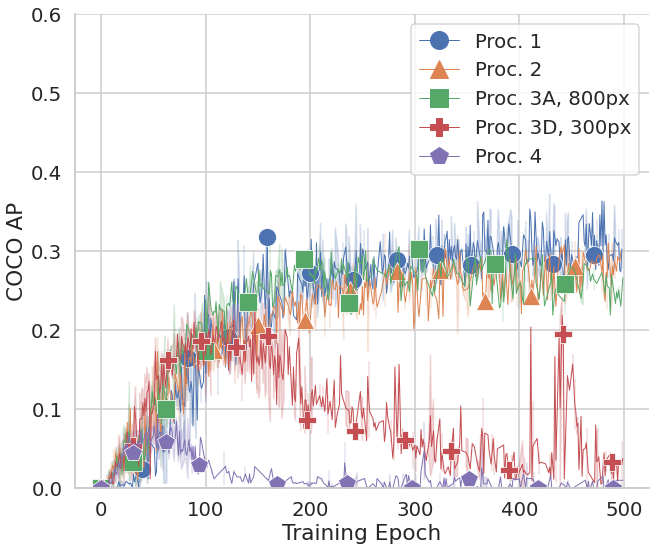

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

figsize = (10, 8)
markers = [
    'o', '^', 's', "P", "p"
]

size_kwargs = dict(
    height=figsize[1],
    aspect=figsize[0]/figsize[1],
    markevery=31,
    dashes=False,
    markers=markers,
)

sns.set(
    context='talk',
    style='whitegrid',
    font_scale=1.2,
    rc={
        'lines.linewidth': 1,
        'figure.figsize': figsize,
        'lines.markersize': 18,
    }
)


fig = sns.relplot(
    data=df[df[CROP_SIZE].isin([800, 300, -1])],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line',
    style=PROC, ci='sd',
    **size_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend()
fig.savefig(fig_path / 'COCO_AP_proc_1_2_3_4.png')

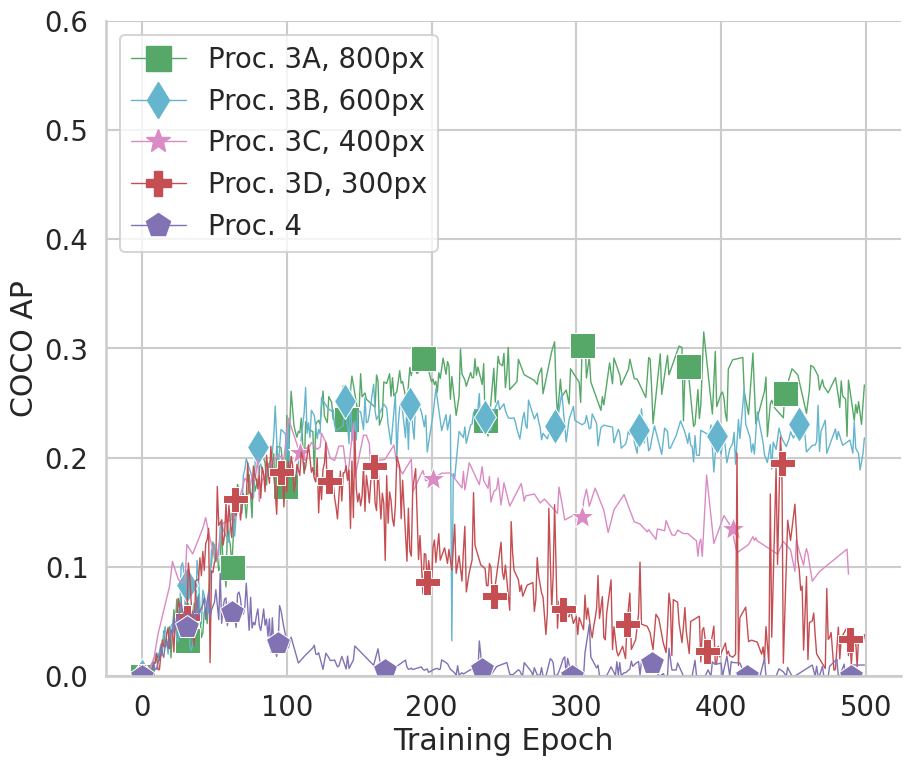

In [7]:
colors = sns.color_palette()
proc_3_4_kwargs = {
    **size_kwargs,
    'markers': [
        's', 'd', '*', 'P', 'p'
    ],
    'palette': [
        colors[2], colors[-1], colors[6], colors[3], colors[4]
    ]
}

fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_3_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='upper left')
fig.savefig(fig_path / 'COCO_AP_procs_3_4.png')

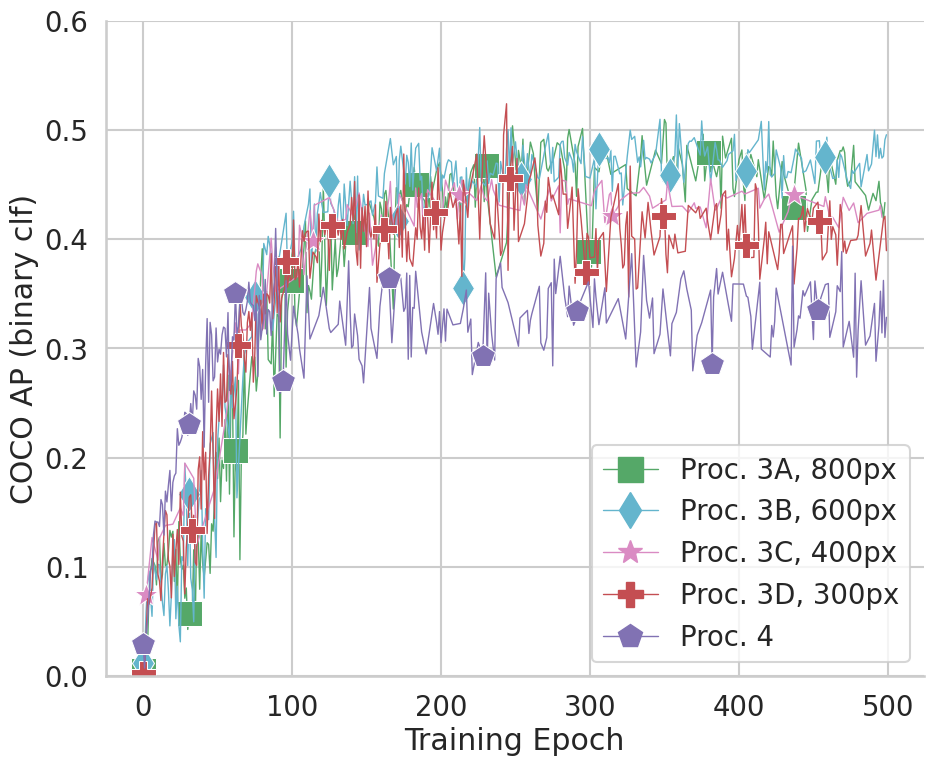

In [8]:
fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP_BIN, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_3_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'COCO_AP_binary_procs_3_4.png')

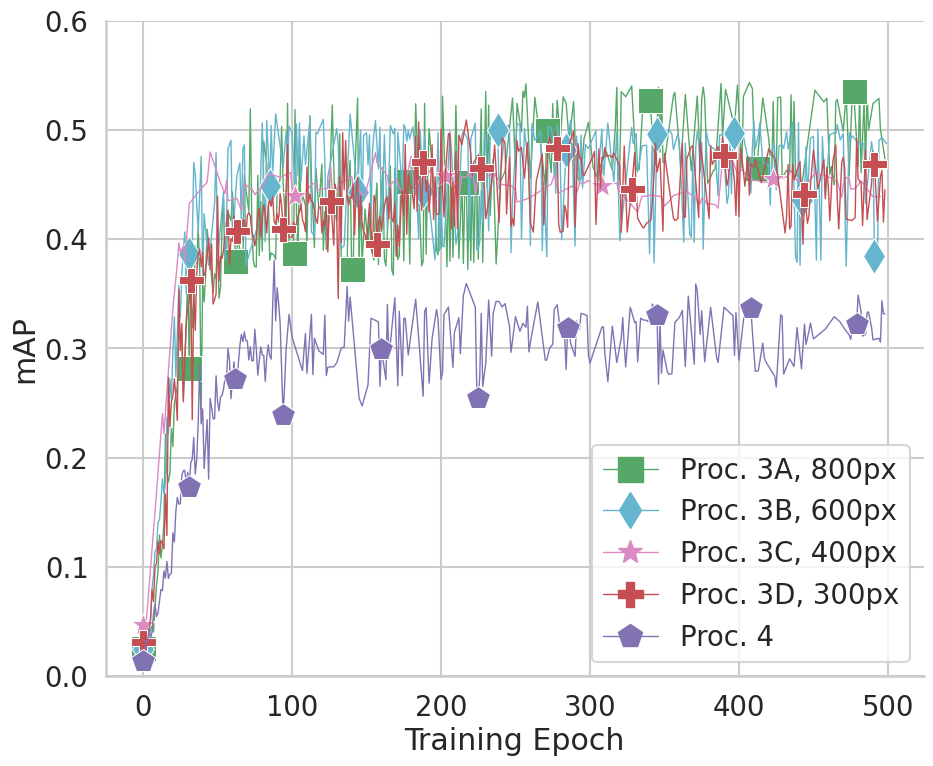

In [9]:
fig = sns.relplot(
    data=df[df[PROC].isin(PROCS_3_4)].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=RECOG_AP, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_3_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
plt.legend(loc='lower right')
fig.savefig(fig_path / 'mAP_procs_3_4_sizes.png')

# Only Proc. 4

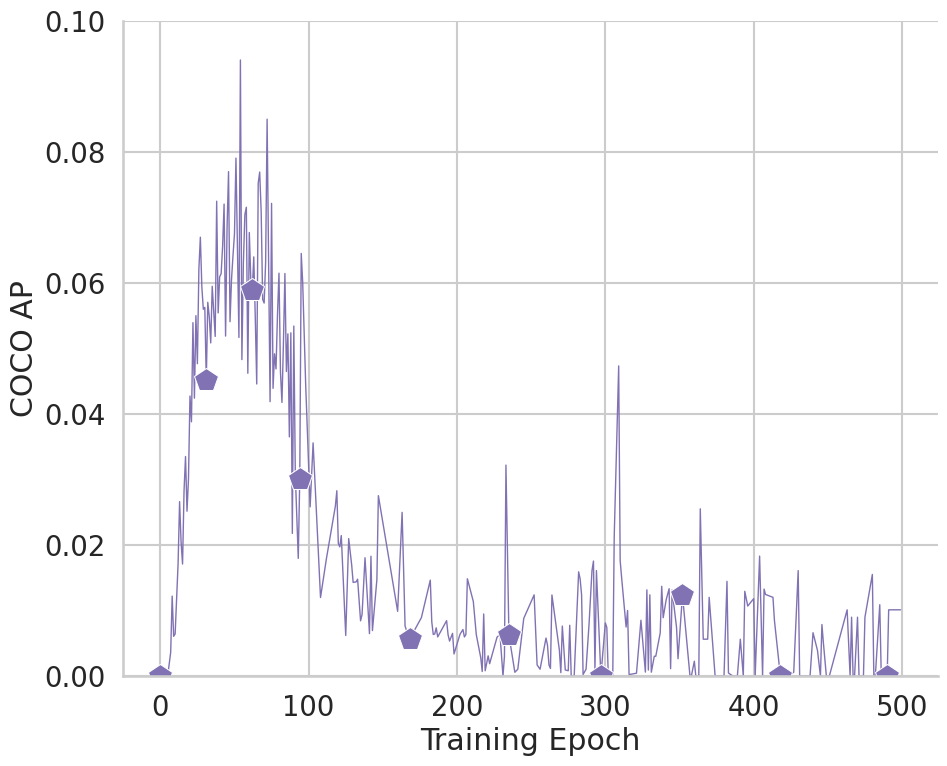

In [10]:
proc_4_kwargs = {
    **size_kwargs,
    'markers': [
        'p'
    ],
    'palette': [
        colors[4]
    ]
}

fig = sns.relplot(
    data=df[df[PROC] == PROC_4],
    x=EPOCH, y=COCO_AP, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_4_kwargs
)
fig.legend.remove()
fig.set(ylim=(0, 0.1))
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'COCO_AP_proc_4.png')

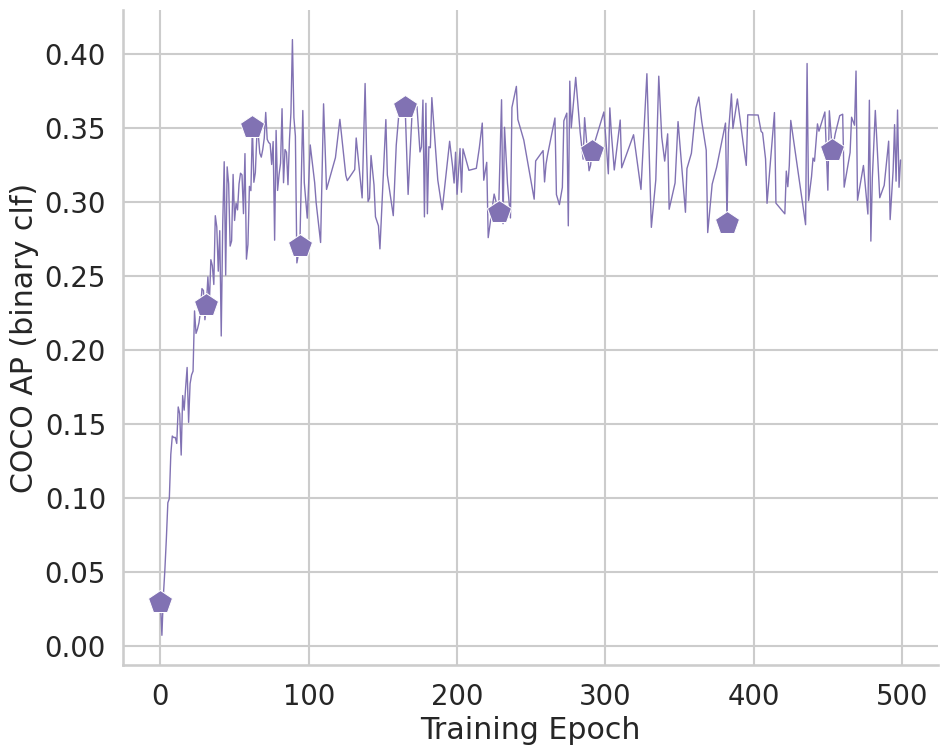

In [11]:
fig = sns.relplot(
    data=df[df[PROC] == PROC_4].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=COCO_AP_BIN, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_4_kwargs
)
fig.legend.remove()
#fig.set(ylim=(0, 0.6))
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'COCO_AP_binary_proc_4.png')

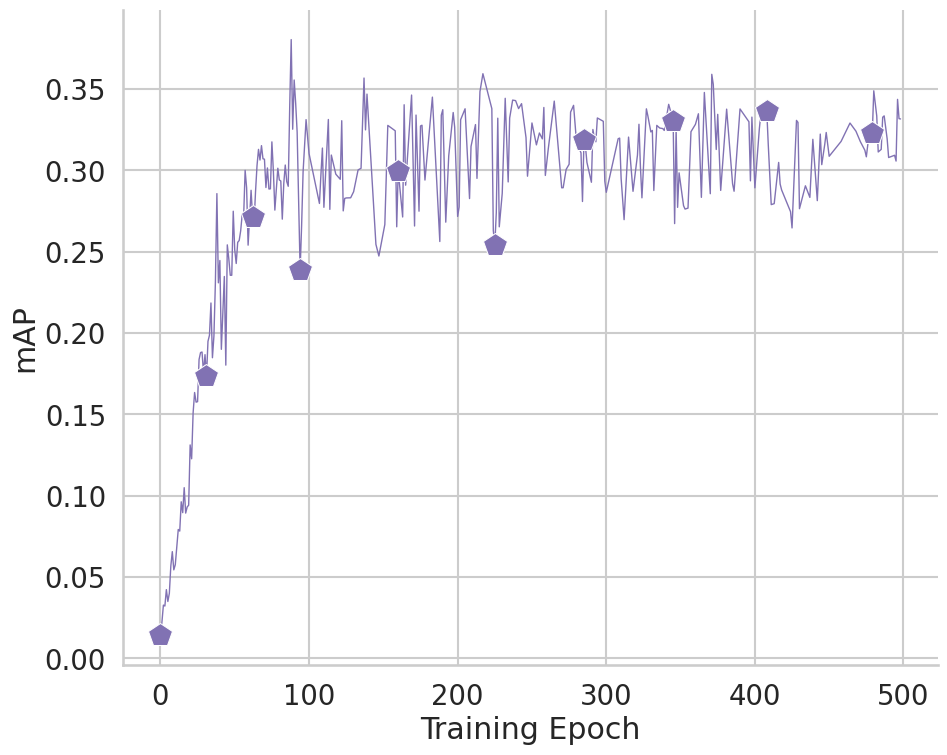

In [12]:
fig = sns.relplot(
    data=df[df[PROC] == PROC_4].sort_values(by=CROP_SIZE, ascending=False),
    x=EPOCH, y=RECOG_AP, hue=PROC, kind='line', style=PROC,
    ci=None, **proc_4_kwargs
)
fig.legend.remove()
#fig.set(xlim=(0, 400))
fig.savefig(fig_path / 'mAP_proc_4_sizes.png')